# Productivity prediction

Dataset consists of 1197 observations of details of productivity in a company in the Garment Industry.
It is avaiable to download here: https://www.kaggle.com/ishadss/productivity-prediction-of-garment-employees
<br><br>
Columns description:

01 date : Date in MM-DD-YYYY <br>
02 day : Day of the Week<br>
03 quarter : A portion of the month. A month was divided into four quarters<br>
04 department : Associated department with the instance<br>
05 teamno : Associated team number with the instance 06 noofworkers : Number of workers in each team <br>
07 noofstylechange : Number of changes in the style of a particular product<br>
08 targetedproductivity : Targeted productivity set by the Authority for each team for each day.<br>
09 smv : Standard Minute Value, it is the allocated time for a task <br>
10 wip : Work in progress. Includes the number of unfinished items for products <br>
11 overtime : Represents the amount of overtime by each team in minutes<br>
12 incentive : Represents the amount of financial incentive (in BDT) that enables or motivates a particular course of action.<br>
13 idletime : The amount of time when the production was interrupted due to several reasons <br>
14 idlemen : The number of workers who were idle due to production interruption<br>
15 actual_productivity : The actual % of productivity that was delivered by the workers. It ranges from 0-1.<br>

### 1. Data preparation 

In [57]:
# import packages
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import feature_selection
import warnings
from sklearn import metrics
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import KFold
from sklearn import neighbors
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.svm import SVC
import pickle
import gc
import math
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from sklearn import preprocessing
%matplotlib inline

In [113]:
###### Initial preparation of data ######
# import data
df = pd.read_csv("garments_worker_productivity.csv",dtype={"team":str, "no_of_style_change":str, 
                                                           "idle_men":int})
#create explanatory variable
df.loc[df['targeted_productivity'] > df['actual_productivity'], 'target'] = 0
df.loc[df['targeted_productivity'] <= df['actual_productivity'], 'target'] = 1
#fix issue with dates - extract only months
df["date"] = df["date"].str.extract(r'(\w+)/', expand=False)
df = df.rename(columns={"date": "month"})
# quarter is not needed, as we only have 3 months in data and also column has wrong values
del df['quarter']
#we need to strip department column from white spaces
df.department = df.department.str.strip()

In [114]:
df.head()

,month,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,target
0,1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725,1.0
1,1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500,1.0
2,1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570,1.0
3,1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570,1.0
4,1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382,1.0


In [115]:
df.dtypes

month                     object
department                object
day                       object
team                      object
targeted_productivity    float64
smv                      float64
wip                      float64
over_time                  int64
incentive                  int64
idle_time                float64
idle_men                   int32
no_of_style_change        object
no_of_workers            float64
actual_productivity      float64
target                   float64
dtype: object

In [116]:
df.isna().sum(axis = 0)

month                      0
department                 0
day                        0
team                       0
targeted_productivity      0
smv                        0
wip                      506
over_time                  0
incentive                  0
idle_time                  0
idle_men                   0
no_of_style_change         0
no_of_workers              0
actual_productivity        0
target                     0
dtype: int64

In [117]:
#It looks like only var "wip" has some missings, lets see how much in % of total data 
df["wip"].isna().sum()/len(df)

0.4227234753550543

As one can see, the number of missing data for variable "wip" reached over 40% of total row number. In this case, we will remove the variable since it is too big gap for us to fill.

In [118]:
del df['wip']

In [119]:
#descriptive statistics
df.describe()

,targeted_productivity,smv,over_time,incentive,idle_time,idle_men,no_of_workers,actual_productivity,target
count,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000
mean,0.729632,15.062172,4567.460317,38.210526,0.730159,0.369256,34.609858,0.735091,0.730994
std,0.097891,10.943219,3348.823563,160.182643,12.709757,3.268987,22.197687,0.174488,0.443628
min,0.070000,2.900000,0.000000,0.000000,0.000000,0.000000,2.000000,0.233705,0.000000
25%,0.700000,3.940000,1440.000000,0.000000,0.000000,0.000000,9.000000,0.650307,0.000000
50%,0.750000,15.260000,3960.000000,0.000000,0.000000,0.000000,34.000000,0.773333,1.000000
75%,0.800000,24.260000,6960.000000,50.000000,0.000000,0.000000,57.000000,0.850253,1.000000
max,0.800000,54.560000,25920.000000,3600.000000,300.000000,45.000000,89.000000,1.120437,1.000000


As can be seen from the descriptive statistics above, second quartile for variables such as *incentive*, *idle_time* & *idle_men* are equal to 0, wheras mean is above 0. Therefore we have extraordinary number of zeros in our dataset for those variables. Because of that, we decided to decode them to dummy variables.

In [120]:
# Decoding incentive to 3 levels
df.loc[(df['incentive'] == 0) , "incentive_categorized"  ]  = "0"
df.loc[(df['incentive'] > 0) & ((df['incentive']) <= 1000 ) , "incentive_categorized" ]  = "1"
df.loc[(df['incentive'] > 1000) , "incentive_categorized" ]  = "2"
# Then delete the incentive variable
del df["incentive"]

In [121]:
# Decoding idle_time to 2 levels
df.loc[(df['idle_time'] == 0) , "idle_time_categorized"  ]  = "0"
df.loc[(df['idle_time']) > 0 , "idle_time_categorized" ]  = "1"
# Then delete the idle_time variable
del df["idle_time"]

In [122]:
# Decoding idle_men to 2 levels
df.loc[(df['idle_men'] == 0) , "idle_men_categorized"  ]  = "0"
df.loc[(df['idle_men']) > 0 , "idle_men_categorized" ]  = "1"
# Then delete the idle_men variable
del df["idle_men"]

### 2. Feature selections.

In [123]:
#Prepare list of numeric and categorical columns 
levCols = []
numCols = []
for col in df.columns:
    if df[col].dtype==object:
        levCols.append(col)
    else:
        numCols.append(col)

#delete vars, which were used to create the dependent variable
numCols.remove("targeted_productivity")
numCols.remove("actual_productivity")

features = numCols + levCols
# target is dependent variable, so we delete it
features.remove("target")
numCols.remove("target")

In [124]:
# Analyze the distribution of variables
for var in levCols:
    print(var)
    display(((pd.crosstab(df["target"], df[var], margins=True)/df.shape[0])*100).round(1))

month


month,1,2,3,All
target,,,,
0.0,9.9,12.5,4.4,26.9
1.0,35.3,24.5,13.3,73.1
All,45.3,37.0,17.7,100.0


department


department,finishing,sweing,All
target,,,
0.0,17.0,9.9,26.9
1.0,25.2,47.9,73.1
All,42.3,57.7,100.0


day


day,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,All
target,,,,,,,
0.0,3.8,3.8,5.3,5.4,4.1,4.3,26.9
1.0,12.8,11.8,11.6,11.2,12.7,13.0,73.1
All,16.6,15.6,17.0,16.6,16.8,17.4,100.0


team


team,1,10,11,12,2,3,4,5,6,7,8,9,All
target,,,,,,,,,,,,,
0.0,1.3,2.5,2.1,1.3,2.3,0.9,1.6,2.1,2.6,3.3,4.1,2.8,26.9
1.0,7.5,5.8,5.3,6.9,6.9,7.0,7.2,5.7,5.3,4.7,5.0,5.8,73.1
All,8.8,8.4,7.4,8.3,9.1,7.9,8.8,7.8,7.9,8.0,9.1,8.7,100.0


no_of_style_change


no_of_style_change,0,1,2,All
target,,,,
0.0,23.5,2.9,0.5,26.9
1.0,64.2,6.6,2.3,73.1
All,87.7,9.5,2.8,100.0


incentive_categorized


incentive_categorized,0,1,2,All
target,,,,
0.0,22.5,4.3,0.2,26.9
1.0,28.0,44.9,0.3,73.1
All,50.5,49.1,0.4,100.0


idle_time_categorized


idle_time_categorized,0,1,All
target,,,
0.0,25.7,1.2,26.9
1.0,72.8,0.3,73.1
All,98.5,1.5,100.0


idle_men_categorized


idle_men_categorized,0,1,All
target,,,
0.0,25.7,1.2,26.9
1.0,72.8,0.3,73.1
All,98.5,1.5,100.0


Let's analyze the descriptive statistics

1. Categorized

In [125]:
# Firstly, we need to encode the str into int variables to obtain corelation metrics
df_copy = df.copy()
le = preprocessing.LabelEncoder()
for col in levCols:
    df_copy[col] = le.fit_transform(df_copy[col])

warnings.simplefilter(action='ignore', category=FutureWarning)

# Print correlation metrics
minfos=[]
for var in levCols:
    print("\n", var)
    print("Pearson", stats.pearsonr(df_copy["target"], df_copy[var]))
    # Random state set to 0 for Mutual Info
    print("Mutual info", feature_selection.mutual_info_classif(df_copy[var].values.reshape(-1,1),df_copy["target"].values, random_state = 0))
    minfos.append(feature_selection.mutual_info_classif(df_copy[var].values.reshape(-1,1),df_copy["target"].values, random_state=0))
    print("Chi2", feature_selection.chi2(df_copy[var].values.reshape(-1,1),df_copy["target"].values))
    print("Anova", feature_selection.f_classif(df_copy[var].values.reshape(-1,1),df_copy["target"].values))

imp = list(zip(minfos, levCols))
imp.sort(reverse=True)
imp


 month
Pearson (-0.057643560443521244, 0.046162074399216914)
Mutual info [0.01927889]
Chi2 (array([3.04161998]), array([0.08115489]))
Anova (array([3.984045], dtype=float32), array([0.04615975], dtype=float32))

 department
Pearson (0.25888637532281716, 8.775348222054219e-20)
Mutual info [0.01963103]
Chi2 (array([33.9132106]), array([5.76260863e-09]))
Anova (array([85.84513], dtype=float32), array([8.774773e-20], dtype=float32))

 day
Pearson (-0.009713387050659699, 0.7370838757260346)
Mutual info [0.00737069]
Chi2 (array([0.13087163]), array([0.71753001]))
Anova (array([0.1126998], dtype=float32), array([0.7371501], dtype=float32))

 team
Pearson (-0.14742253143349449, 3.0044716314587723e-07)
Mutual info [0.02188792]
Chi2 (array([57.09675386]), array([4.14889915e-14]))
Anova (array([26.548443], dtype=float32), array([3.0044117e-07], dtype=float32))

 no_of_style_change
Pearson (0.006259942235053839, 0.8287107527834078)
Mutual info [0]
Chi2 (array([0.05705217]), array([0.81121727]))
A

[(array([0.07920106]), 'incentive_categorized'),
 (array([0.02188792]), 'team'),
 (array([0.01963103]), 'department'),
 (array([0.01927889]), 'month'),
 (array([0.00737069]), 'day'),
 (array([0]), 'no_of_style_change'),
 (array([0]), 'idle_time_categorized'),
 (array([0]), 'idle_men_categorized')]

The most important value seems to be incentive_categorized, which mutual information has the highest value. The least important are: no_of_style_change, is_idle_time_categorized, no_of_style_change.

2. Continuous 

In [126]:
warnings.simplefilter(action='ignore', category=FutureWarning)
minfos=[]
for var in numCols:
    print(var, " Mutual info", feature_selection.mutual_info_regression(df_copy[var].astype(float).values.reshape(-1,1),df_copy["target"].astype(float).values, random_state =  0))
    minfos.append(feature_selection.mutual_info_regression(df_copy[var].astype(float).values.reshape(-1,1),df_copy["target"].astype(float).values, random_state =  0))
# We can sort recorded values
imp = list(zip(minfos, numCols))
imp.sort(reverse=True)
imp

smv  Mutual info [0.134211]
over_time  Mutual info [0.03991998]
no_of_workers  Mutual info [0.05295754]


[(array([0.134211]), 'smv'),
 (array([0.05295754]), 'no_of_workers'),
 (array([0.03991998]), 'over_time')]

Above there are values of mutual information for continuous variables. The highest one is for smv.
Now, let's decode the variables to dummies and see the most significant relationship in logistic regression. 

In [130]:
levCols

['month',
 'department',
 'day',
 'team',
 'no_of_style_change',
 'incentive_categorized',
 'idle_time_categorized']

In [128]:
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
del df["idle_men_categorized"]
levCols.remove("idle_men_categorized")

In [131]:
# Firstly we need to append back target to our variables
numCols.append("target")
# Binarization of nominal variables along with target variable
dummLev = pd.get_dummies(df[levCols], drop_first = True)
df_dummy = pd.concat([df[numCols], dummLev], axis=1)
# And remove target from numCols to standarize the explanatory variables
numCols.remove("target")
# Let's standarize our results
df_dummy[numCols] = df_dummy[numCols].apply(lambda x: (x-x.mean())/x.std())

In [132]:
# Gather all column names once again after binarization
features = df_dummy.columns.tolist()
features.remove("target")

In [133]:
features

['smv',
 'over_time',
 'no_of_workers',
 'month_2',
 'month_3',
 'department_sweing',
 'day_Saturday',
 'day_Sunday',
 'day_Thursday',
 'day_Tuesday',
 'day_Wednesday',
 'team_10',
 'team_11',
 'team_12',
 'team_2',
 'team_3',
 'team_4',
 'team_5',
 'team_6',
 'team_7',
 'team_8',
 'team_9',
 'no_of_style_change_1',
 'no_of_style_change_2',
 'incentive_categorized_1',
 'incentive_categorized_2',
 'idle_time_categorized_1']

In [134]:
# Now lets try logistic regression
aucs=[]
for var in features:
    mod = sm.GLM.from_formula(formula="target ~ " + var, data=df_dummy, family=sm.families.Binomial())
    res = mod.fit()
    probs = res.predict()
    aucs.append(metrics.roc_auc_score(df_dummy["target"].values, probs))

print("\n", "--------------", "\n")
imp = list(zip(aucs, features))
imp.sort(reverse=True)
imp


 -------------- 



[(0.727664596273292, 'incentive_categorized_1'),
 (0.6744081632653061, 'no_of_workers'),
 (0.6441987577639751, 'department_sweing'),
 (0.6408731144631765, 'over_time'),
 (0.6348127772848269, 'smv'),
 (0.5654906832298137, 'month_2'),
 (0.5418012422360249, 'team_8'),
 (0.5309192546583852, 'team_3'),
 (0.530111801242236, 'team_7'),
 (0.524360248447205, 'day_Thursday'),
 (0.5225838509316769, 'team_12'),
 (0.5199503105590062, 'day_Sunday'),
 (0.5196397515527951, 'team_4'),
 (0.5194534161490683, 'idle_time_categorized_1'),
 (0.5127950310559006, 'team_9'),
 (0.5121366459627329, 'team_6'),
 (0.5107701863354037, 'day_Tuesday'),
 (0.5092049689440994, 'no_of_style_change_1'),
 (0.5091428571428571, 'day_Saturday'),
 (0.5085590062111801, 'month_3'),
 (0.5083975155279503, 'day_Wednesday'),
 (0.506583850931677, 'team_10'),
 (0.5061118012422361, 'no_of_style_change_2'),
 (0.5049316770186335, 'team_2'),
 (0.5028198757763975, 'team_11'),
 (0.5013913043478261, 'incentive_categorized_2'),
 (0.500037267080

In [135]:
# Choose approperiate variables
chosen_vars = []
for auc,var in imp:
    if auc>= 0.51:
        chosen_vars.append(var)
        chosen_vars
chosen_vars

['incentive_categorized_1',
 'no_of_workers',
 'department_sweing',
 'over_time',
 'smv',
 'month_2',
 'team_8',
 'team_3',
 'team_7',
 'day_Thursday',
 'team_12',
 'day_Sunday',
 'team_4',
 'idle_time_categorized_1',
 'team_9',
 'team_6',
 'day_Tuesday']

We decide to remove observations with auc below 0.51 to improve the model. Most of the values that were pointed above were also important in logit model. <br> Next step is to create models: Logit, SVM and KNN.

### Modelling

#### 3.1. Logit model

In [136]:
all_columns = "+".join(chosen_vars)
my_formula = "target ~" + all_columns
my_formula # formula used in code for logit model

'target ~incentive_categorized_1+no_of_workers+department_sweing+over_time+smv+month_2+team_8+team_3+team_7+day_Thursday+team_12+day_Sunday+team_4+idle_time_categorized_1+team_9+team_6+day_Tuesday'

In [137]:
mod = sm.GLM.from_formula(formula = my_formula , data= df_dummy, family=sm.families.Binomial())
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 target   No. Observations:                 1197
Model:                            GLM   Df Residuals:                     1179
Model Family:                Binomial   Df Model:                           17
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -530.76
Date:                Tue, 01 Jun 2021   Deviance:                       1061.5
Time:                        23:36:11   Pearson chi2:                 1.36e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.9801      0.393      2.493      0.013       0.210       1.751
incentive_categorized_1     2.6607      0.283      9.412      0.000       2.107       3.215
no_of_workers               1.7037      0.406      4.201      0.000       0.909       2.499
department_sweing          -0.8160      0.680     -1.199      0.230      -2.150       0.518
over_time                  -0.3378      0.146     -2.316      0.021      -0.624      -0.052
smv                        -1.3382      0.215     -6.219      0.000      -1.760      -0.916
month_2                    -0.4472      0.170     -2.624      0.009      -0.781      -0.113
team_8                     -0.6663      0.254     -2.624      0.009      -1.164      -0.169
team_3                      0.8311      0.362      2.294      0.022       0.121       1.541
team_7                     -0.4591      0.270     -1.699      0.089      -0.989       0.071
day_Thursday               -0.4513      0.214     -2.108      0.035      -0.871      -0.032
team_12                     0.4978      0.338      1.475      0.140      -0.164       1.159
day_Sunday                 -0.3213      0.209     -1.537      0.124      -0.731       0.088
team_4                      0.4584      0.307      1.491      0.136      -0.144       1.061
idle_time_categorized_1    -2.2754      0.732     -3.108      0.002      -3.710      -0.840
team_9                     -0.6059      0.270     -2.246      0.025      -1.135      -0.077
team_6                     -0.3196      0.320     -0.999      0.318      -0.946       0.307
day_Tuesday                -0.0613      0.218     -0.281      0.779      -0.489       0.366
===========================================================================================
"""

To choose the best number of KFolds, we run logit model and get a mean value od AUC.

In [143]:
folds = [4,5,6,7,8,9,10]
for f in folds:
    trainRes = []
    valRes = []
    
    kf = KFold(n_splits=f, shuffle=True, random_state = 0)

    for train, test in kf.split(df_dummy.index.values):
        mod = sm.GLM.from_formula(formula=my_formula, data=df_dummy.iloc[train], family=sm.families.Binomial())
        res = mod.fit()
        predsTrain = res.predict()
        preds = res.predict(df_dummy.iloc[test])
        trainRes.append(roc_auc_score(df_dummy.iloc[train].target, predsTrain))
        valRes.append(roc_auc_score(df_dummy.iloc[test].target, preds))
    print("KFolds:", f, "Train AUC:", np.mean(trainRes), "Valid AUC:", np.mean(valRes))

KFolds: 4 Train AUC: 0.8265157165427626 Valid AUC: 0.8053161082792353
KFolds: 5 Train AUC: 0.8258335701552288 Valid AUC: 0.8096141608885592
KFolds: 6 Train AUC: 0.8253904212860235 Valid AUC: 0.8123012901332656
KFolds: 7 Train AUC: 0.8251682335381167 Valid AUC: 0.8096398618560862
KFolds: 8 Train AUC: 0.8251798263497881 Valid AUC: 0.8050650676285648
KFolds: 9 Train AUC: 0.8248974302563744 Valid AUC: 0.8116833316787488
KFolds: 10 Train AUC: 0.8248913080028727 Valid AUC: 0.8070632646611751


It seems that for KFolds = 6, Valid AUC is the best. <br>
KFolds: 6 <br>
Train AUC: 0.8254 <br> Valid AUC: 0.8123

In [145]:
trainRes = []
valRes = []
    
kf = KFold(n_splits=6, shuffle=True,random_state = 0)

for train, test in kf.split(df_dummy.index.values):
    mod = sm.GLM.from_formula(formula=my_formula, data=df_dummy.iloc[train], family=sm.families.Binomial())
    res = mod.fit()
    predsTrain = res.predict()
    preds = res.predict(df_dummy.iloc[test])
    trainRes.append(roc_auc_score(df_dummy.iloc[train].target, predsTrain))
    valRes.append(roc_auc_score(df_dummy.iloc[test].target, preds))
print("Train AUC:", np.mean(trainRes), "Valid AUC:", np.mean(valRes))

Train AUC: 0.8253904212860235 Valid AUC: 0.8123012901332656


#### 3.2. SVM

First step is to choose the best kernel.

In [160]:
aucs = []
aucsT = []
clf = SVC(C = 1, cache_size=500, kernel= 'linear',
          max_iter=-1, probability=True,
          tol=0.001, verbose=False, random_state = 3)
for train, test in kf.split(df_dummy.index.values):
    clf.fit(df_dummy.iloc[train][chosen_vars].values, df_dummy.iloc[train]["target"].values)
    prob = clf.predict_proba(df_dummy.iloc[test][chosen_vars])
    aucs.append(metrics.roc_auc_score(df_dummy.iloc[test]["target"].values, prob[:,1])) 

    prob2 = clf.predict_proba(df_dummy.iloc[train][chosen_vars])
    aucsT.append(metrics.roc_auc_score(df_dummy.iloc[train]["target"].values, prob2[:,1]))

print("Train set: ", np.mean(aucsT))
print("Validation set: ", np.mean(aucs))
print("----------------------------")

Train set:  0.8151828996935742
Validation set:  0.7945511267335759
----------------------------


In [161]:
degrees = [2,3,4,5]

for d in degrees:
    aucs = []
    aucsT = []
    clf = SVC(C = 1, cache_size=500, kernel= 'poly', degree = d,
              max_iter=-1, probability=True,
              tol=0.001, verbose=False, random_state = 0)
    for train, test in kf.split(df_dummy.index.values):
        clf.fit(df_dummy.iloc[train][chosen_vars].values, df_dummy.iloc[train]["target"].values)
        prob = clf.predict_proba(df_dummy.iloc[test][chosen_vars])
        aucs.append(metrics.roc_auc_score(df_dummy.iloc[test]["target"].values, prob[:,1])) 

        prob2 = clf.predict_proba(df_dummy.iloc[train][chosen_vars])
        aucsT.append(metrics.roc_auc_score(df_dummy.iloc[train]["target"].values, prob2[:,1]))
    print("Degree: ", d)
    print("Train set: ", np.mean(aucsT))
    print("Validation set: ", np.mean(aucs))
    print("----------------------------")

Degree:  2
Train set:  0.8554274266868488
Validation set:  0.809066634545422
----------------------------
Degree:  3
Train set:  0.8682398589014071
Validation set:  0.8102489513738547
----------------------------
Degree:  4
Train set:  0.8819805885617858
Validation set:  0.7939778534207277
----------------------------
Degree:  5
Train set:  0.8945734048446934
Validation set:  0.7887679172437074
----------------------------


Best AUC score is for degree equal to 3.

In [162]:
aucs = []
aucsT = []
clf = SVC(C = 1, cache_size=500, kernel= 'rbf', 
          max_iter=-1, probability=True,
          tol=0.001, verbose=False, random_state = 0)
for train, test in kf.split(df_dummy.index.values):
    clf.fit(df_dummy.iloc[train][chosen_vars].values, df_dummy.iloc[train]["target"].values)
    prob = clf.predict_proba(df_dummy.iloc[test][chosen_vars])
    aucs.append(metrics.roc_auc_score(df_dummy.iloc[test]["target"].values, prob[:,1])) 

    prob2 = clf.predict_proba(df_dummy.iloc[train][chosen_vars])
    aucsT.append(metrics.roc_auc_score(df_dummy.iloc[train]["target"].values, prob2[:,1]))
print("Train set: ", np.mean(aucsT))
print("Validation set: ", np.mean(aucs))
print("----------------------------")

Train set:  0.8631215461588649
Validation set:  0.8140547649370614
----------------------------


The best AUC score is for RBF kernel, so we will proceed with this kernel type. <br>
Next step is to choose the best number of Folds.

In [165]:
K = [3, 5, 8, 10]

for k in K:
    kf = KFold(n_splits=k, random_state=0, shuffle =True)

    aucs = []
    aucsT = []
    clf = SVC(C = 1, cache_size=500, kernel= 'rbf', 
              max_iter=-1, probability=True,
              tol=0.001, verbose=False, random_state = 0)
    for train, test in kf.split(df_dummy.index.values):
        clf.fit(df_dummy.iloc[train][chosen_vars].values, df_dummy.iloc[train]["target"].values)
        prob = clf.predict_proba(df_dummy.iloc[test][chosen_vars])
        aucs.append(metrics.roc_auc_score(df_dummy.iloc[test]["target"].values, prob[:,1])) 

        prob2 = clf.predict_proba(df_dummy.iloc[train][chosen_vars])
        aucsT.append(metrics.roc_auc_score(df_dummy.iloc[train]["target"].values, prob2[:,1]))
        
    print("KFolds: ", k) 
    print("Train set: ", np.mean(aucsT))
    print("Validation set: ", np.mean(aucs))
    print("----------------------------")

KFolds:  3
Train set:  0.8705632667501377
Validation set:  0.8097935841804449
----------------------------
KFolds:  5
Train set:  0.8659458759191836
Validation set:  0.8174221058731194
----------------------------
KFolds:  8
Train set:  0.8633774329516467
Validation set:  0.8101636070010771
----------------------------
KFolds:  10
Train set:  0.8631215461588649
Validation set:  0.8140547649370614
----------------------------


The best AUC score is for 5 Folds. <br>
Train set:  0.8659
Validation set:  0.8174 <br>
Next step is to choose the best cost regularization parameter.

In [198]:
kf = KFold(n_splits=5, random_state=0, shuffle =True)

C = [0.01, 0.1, 0.5, 1, 2, 3, 5, 10]

for c in C:
    aucs = []
    aucsT = []
    clf = SVC(C = c, cache_size=500, kernel= 'rbf',
              max_iter=-1, probability=True,
              tol=0.001, verbose=False, random_state = 0)
    for train, test in kf.split(df_dummy.index.values):
        clf.fit(df_dummy.iloc[train][chosen_vars].values, df_dummy.iloc[train]["target"].values)
        prob = clf.predict_proba(df_dummy.iloc[test][chosen_vars])
        aucs.append(metrics.roc_auc_score(df_dummy.iloc[test]["target"].values, prob[:,1])) 

        prob2 = clf.predict_proba(df_dummy.iloc[train][chosen_vars])
        aucsT.append(metrics.roc_auc_score(df_dummy.iloc[train]["target"].values, prob2[:,1]))
    print("Cost: ", c)
    print("Train set: ", np.mean(aucsT))
    print("Validation set: ", np.mean(aucs))
    print("----------------------------")

Cost:  0.01
Train set:  0.8549303193640909
Validation set:  0.8158034263839747
----------------------------
Cost:  0.1
Train set:  0.8552462948321853
Validation set:  0.8163902403232033
----------------------------
Cost:  0.5
Train set:  0.8592479477314626
Validation set:  0.8180569847757548
----------------------------
Cost:  1
Train set:  0.8659458759191836
Validation set:  0.8174221058731194
----------------------------
Cost:  2
Train set:  0.8738649087671135
Validation set:  0.8125450016901101
----------------------------
Cost:  3
Train set:  0.8806512699922717
Validation set:  0.8083397036065622
----------------------------
Cost:  5
Train set:  0.8884978113717867
Validation set:  0.8069082026123123
----------------------------
Cost:  10
Train set:  0.9008625731050625
Validation set:  0.8026133110494531
----------------------------


The best AUC score is for cost parameter 0.5. <br>
Train set:  0.8592
Validation set:  0.8181 <br> <br>
To sum up, the best model is SVM with parameters: kernel = rbf, kfolds = 5 and c = 0.5.  

In [199]:
kf = KFold(n_splits=5, random_state=0, shuffle =True)

aucs = []
aucsT = []
clf = SVC(C = 0.5, cache_size=500, kernel= 'rbf',
          max_iter=-1, probability=True,
          tol=0.001, verbose=False, random_state = 0)
for train, test in kf.split(df_dummy.index.values):
    clf.fit(df_dummy.iloc[train][chosen_vars].values, df_dummy.iloc[train]["target"].values)
    prob_SVM = clf.predict_proba(df_dummy.iloc[test][chosen_vars])
    aucs.append(metrics.roc_auc_score(df_dummy.iloc[test]["target"].values, prob_SVM[:,1])) 

    prob2 = clf.predict_proba(df_dummy.iloc[train][chosen_vars])
    aucsT.append(metrics.roc_auc_score(df_dummy.iloc[train]["target"].values, prob2[:,1]))
print("Cost: ", c)
print("Train set: ", np.mean(aucsT))
print("Validation set: ", np.mean(aucs))
print("----------------------------")

Cost:  10
Train set:  0.8592479477314626
Validation set:  0.8180569847757548
----------------------------


#### 3.3. KNN

First thing is to choose the best folds number for Euclidean and Manhattan distance. 

In [176]:
# Euclidean
K = [3, 5, 8, 10]
for k in K:
    kf = KFold(n_splits=k, shuffle=True, random_state=0)
    probs = []
    indicies = []
    aucs = []
    bacc = []
    accs = []
    n_neighbors = int(math.sqrt(df_dummy.shape[0]))
    clf = neighbors.KNeighborsClassifier(n_neighbors, n_jobs=-1, p=1)
    for train, test in kf.split(df_dummy.index.values):
        clf.fit(df_dummy.iloc[train][chosen_vars].values, df_dummy.iloc[train]["target"].values)
        prob = clf.predict_proba(df_dummy.iloc[test][chosen_vars].values)
        probs.append(prob)
        indicies.append(test)
        aucs.append(metrics.roc_auc_score(df_dummy.iloc[test]["target"].values, prob[:,1]))
        accs.append(metrics.accuracy_score(df_dummy.iloc[test]["target"].values, (prob[:,1]>0.50).astype(int)))
    print("KFolds: ", k)
    print('AUC: ', np.mean(aucs))
    print('ACC: ',np.mean(accs))


KFolds:  3
AUC:  0.7911797804765718
ACC:  0.7627401837928153
KFolds:  5
AUC:  0.8019740871052313
ACC:  0.7660529986052997
KFolds:  8
AUC:  0.8021276327789599
ACC:  0.7685458612975391
KFolds:  10
AUC:  0.8060769411333666
ACC:  0.7701680672268908


In [175]:
# Manhattan
K = [3, 5, 8, 10]
for k in K:
    kf = KFold(n_splits=k, shuffle=True, random_state=0)
    probs = []
    indicies = []
    aucs = []
    bacc = []
    accs = []
    n_neighbors = int(math.sqrt(df_dummy.shape[0]))
    clf = neighbors.KNeighborsClassifier(n_neighbors, n_jobs=-1, p=2)
    for train, test in kf.split(df_dummy.index.values):
        clf.fit(df_dummy.iloc[train][chosen_vars].values, df_dummy.iloc[train]["target"].values)
        prob = clf.predict_proba(df_dummy.iloc[test][chosen_vars].values)
        probs.append(prob)
        indicies.append(test)
        aucs.append(metrics.roc_auc_score(df_dummy.iloc[test]["target"].values, prob[:,1]))
        accs.append(metrics.accuracy_score(df_dummy.iloc[test]["target"].values, (prob[:,1]>0.50).astype(int)))
    print("KFolds: ", k)
    print('AUC: ', np.mean(aucs))
    print('ACC: ',np.mean(accs))


KFolds:  3
AUC:  0.7942295560352797
ACC:  0.7585630743525481
KFolds:  5
AUC:  0.8000064472863075
ACC:  0.7627161785216179
KFolds:  8
AUC:  0.8027594610024307
ACC:  0.7568400447427293
KFolds:  10
AUC:  0.8060531057081883
ACC:  0.7618137254901961


As we can see above results that we get using Manhattan distance are worse that for Euclidean distance. <br>
The best AUC score and accuracy is for 10 folds. <br>
AUC:  0.8061
ACC:  0.7702 <br> <br>
Next thing is to choose better neighbors number.

In [179]:
neighbors_list = [0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3]
for n in neighbors_list:
    kf = KFold(n_splits=10, random_state=0, shuffle=True)
    probs = []
    indicies = []
    aucs = []
    bacc = []
    accs = []
    n_neighbors = math.sqrt(df_dummy.shape[0])
    clf = neighbors.KNeighborsClassifier(int(n_neighbors*n), n_jobs=-1, p=1)
    for train, test in kf.split(df_dummy.index.values):
        clf.fit(df_dummy.iloc[train][chosen_vars].values, df_dummy.iloc[train]["target"].values)
        prob = clf.predict_proba(df_dummy.iloc[test][chosen_vars].values)
        probs.append(prob)
        indicies.append(test)
        aucs.append(metrics.roc_auc_score(df_dummy.iloc[test]["target"].values, prob[:,1]))
        accs.append(metrics.accuracy_score(df_dummy.iloc[test]["target"].values, (prob[:,1]>0.50).astype(int)))
    print("Number of neighbours: ", int(n_neighbors*n))
    print('AUC: ', np.mean(aucs))
    print('ACC: ',np.mean(accs))


Number of neighbours:  24
AUC:  0.8113199102539937
ACC:  0.775203081232493
Number of neighbours:  27
AUC:  0.8066482154526604
ACC:  0.7676470588235295
Number of neighbours:  31
AUC:  0.807850099436741
ACC:  0.7601190476190476
Number of neighbours:  34
AUC:  0.8060769411333666
ACC:  0.7701680672268908
Number of neighbours:  38
AUC:  0.8009786892810208
ACC:  0.7726680672268907
Number of neighbours:  41
AUC:  0.7957665486938807
ACC:  0.7593487394957983
Number of neighbours:  44
AUC:  0.7967705784913583
ACC:  0.763515406162465


We get the best AUC for 23 neighbours. <br> <br>
To sum up, the best model is KNN with parameters: p = 1, kfolds = 10 and neighbours = 24.  

In [195]:
kf = KFold(n_splits=10, random_state=0, shuffle=True)
n=0.7
probs = []
indicies = []
aucs = []
bacc = []
accs = []
n_neighbors = math.sqrt(df_dummy.shape[0])
clf = neighbors.KNeighborsClassifier(int(n_neighbors*n), n_jobs=-1, p=1)
for train, test in kf.split(df_dummy.index.values):
    clf.fit(df_dummy.iloc[train][chosen_vars].values, df_dummy.iloc[train]["target"].values)
    prob_KNN = clf.predict_proba(df_dummy.iloc[test][chosen_vars].values)
    probs.append(prob_KNN)
    indicies.append(test)
    aucs.append(metrics.roc_auc_score(df_dummy.iloc[test]["target"].values, prob_KNN[:,1]))
    accs.append(metrics.accuracy_score(df_dummy.iloc[test]["target"].values, (prob_KNN[:,1]>0.50).astype(int)))
print("Number of neighbours: ", int(n_neighbors*n))
print('AUC: ', np.mean(aucs))
print('ACC: ',np.mean(accs))

Number of neighbours:  24
AUC:  0.8113199102539937
ACC:  0.775203081232493


#### Summary and imbalance

As we can see, the best results was developed using SVM model with parameters: kernel = rbf, kfolds = 5 and c = 0.5 >> AUC = 0.81801. <br>This database is imbalanced and there are not many observations so we decided to use SMOTE for oversampling and see if it works.

In [207]:
from sklearn.model_selection import train_test_split
test_size = 0.4 # because we will increase number of observations in traindata, so here we have to also increase the test size
gTrain, gValid = train_test_split(df_dummy, test_size=test_size, random_state=2017, stratify=df_dummy["target"].values)

In [208]:
gValid.target.value_counts()

1.0    350
0.0    129
Name: target, dtype: int64

##### Logit model

In [224]:
from imblearn.over_sampling import SMOTE
smt = SMOTE(sampling_strategy=0.4, random_state=0)
X_resampled, y_resampled = smt.fit_resample(gTrain[chosen_vars], gTrain.target)
df_oversamp_1 = pd.DataFrame(X_resampled, columns=chosen_vars)
df_oversamp_1["target"] = y_resampled
gTrain_1 = df_oversamp_1.copy()
print(gTrain_1.shape,'\n',gTrain_1.target.value_counts())

smt = SMOTE(sampling_strategy=0.5, random_state=0)
X_resampled, y_resampled = smt.fit_resample(gTrain[chosen_vars], gTrain.target)
df_oversamp_2 = pd.DataFrame(X_resampled, columns=chosen_vars)
df_oversamp_2["target"] = y_resampled
gTrain_2 = df_oversamp_2.copy()
print(gTrain_2.shape, '\n', gTrain_2.target.value_counts())

smt = SMOTE(sampling_strategy=0.7, random_state=0)
X_resampled, y_resampled = smt.fit_resample(gTrain[chosen_vars], gTrain.target)
df_oversamp_3 = pd.DataFrame(X_resampled, columns=chosen_vars)
df_oversamp_3["target"] = y_resampled
gTrain_3 = df_oversamp_3.copy()
print(gTrain_3.shape,'\n',gTrain_3.target.value_counts())

(735, 18) 
 1.0    525
0.0    210
Name: target, dtype: int64
(787, 18) 
 1.0    525
0.0    262
Name: target, dtype: int64
(892, 18) 
 1.0    525
0.0    367
Name: target, dtype: int64


In [220]:
mod = sm.GLM.from_formula(formula=my_formula, data=gTrain_1, family=sm.families.Binomial())
res = mod.fit()
predsTrain_1 = res.predict()
preds_1 = res.predict(gValid)
print("Train AUC:", metrics.roc_auc_score(gTrain_1.target, predsTrain_1),
      "Valid AUC:", metrics.roc_auc_score(gValid.target, preds_1))

mod = sm.GLM.from_formula(formula=my_formula, data=gTrain_2, family=sm.families.Binomial())
res = mod.fit()
predsTrain_2 = res.predict()
preds_2 = res.predict(gValid)
print("Train AUC:", metrics.roc_auc_score(gTrain_2.target, predsTrain_2),
      "Valid AUC:", metrics.roc_auc_score(gValid.target, preds_2))

mod = sm.GLM.from_formula(formula=my_formula, data=gTrain_3, family=sm.families.Binomial())
res = mod.fit()
predsTrain_3 = res.predict()
preds_3 = res.predict(gValid)
print("Train AUC:", metrics.roc_auc_score(gTrain_3.target, predsTrain_3),
      "Valid AUC:", metrics.roc_auc_score(gValid.target, preds_3))

Train AUC: 0.8314140312613595 Valid AUC: 0.8072868217054263
Train AUC: 0.8421149604255871 Valid AUC: 0.8109856035437432
Train AUC: 0.849342403628118 Valid AUC: 0.8042303433001108


It seems that it did not help for logit model. Before we get AUC at the level of Valid AUC: 0.8123, and now the best one is about 0.81098. <br>

##### SVM

In [225]:
from imblearn.over_sampling import SMOTE
smt = SMOTE(sampling_strategy=0.5, random_state=0)
X_resampled, y_resampled = smt.fit_resample(gTrain[chosen_vars], gTrain.target)
df_oversamp_1 = pd.DataFrame(X_resampled, columns=chosen_vars)
df_oversamp_1["target"] = y_resampled
gTrain_1 = df_oversamp_1.copy()
print(gTrain_1.shape,'\n',gTrain_1.target.value_counts())

smt = SMOTE(sampling_strategy=0.7, random_state=0)
X_resampled, y_resampled = smt.fit_resample(gTrain[chosen_vars], gTrain.target)
df_oversamp_2 = pd.DataFrame(X_resampled, columns=chosen_vars)
df_oversamp_2["target"] = y_resampled
gTrain_2 = df_oversamp_2.copy()
print(gTrain_2.shape, '\n', gTrain_2.target.value_counts())

smt = SMOTE(sampling_strategy=1, random_state=0)
X_resampled, y_resampled = smt.fit_resample(gTrain[chosen_vars], gTrain.target)
df_oversamp_3 = pd.DataFrame(X_resampled, columns=chosen_vars)
df_oversamp_3["target"] = y_resampled
gTrain_3 = df_oversamp_3.copy()
print(gTrain_3.shape,'\n',gTrain_3.target.value_counts())

(787, 18) 
 1.0    525
0.0    262
Name: target, dtype: int64
(892, 18) 
 1.0    525
0.0    367
Name: target, dtype: int64
(1050, 18) 
 0.0    525
1.0    525
Name: target, dtype: int64


In [226]:
kf = KFold(n_splits=5,random_state=0, shuffle=True)

clf = SVC(C = 0.5, cache_size=500, kernel= 'rbf',
max_iter=-1, probability=True,
tol=0.001, verbose=False, random_state = 0)

aucs = []
aucsT = []
clf.fit(gTrain_1[chosen_vars].values, gTrain_1["target"].values)
prob_o_1 = clf.predict_proba(gValid[chosen_vars])
aucs.append(metrics.roc_auc_score(gValid["target"].values, prob_o_1[:,1]))
prob2_o_1 = clf.predict_proba(gTrain_1[chosen_vars])
aucsT.append(metrics.roc_auc_score(gTrain_1["target"].values, prob2_o_1[:,1]))

print("Train set: ", aucsT)
print("Validation set: ", aucs)
print("----------------------------")

aucs = []
aucsT = []
clf.fit(gTrain_2[chosen_vars].values, gTrain_2["target"].values)
prob_o_2 = clf.predict_proba(gValid[chosen_vars])
aucs.append(metrics.roc_auc_score(gValid["target"].values, prob_o_2[:,1]))
prob2_o_2 = clf.predict_proba(gTrain_2[chosen_vars])
aucsT.append(metrics.roc_auc_score(gTrain_2["target"].values, prob2_o_2[:,1]))

print("Train set: ", aucsT)
print("Validation set: ", aucs)
print("----------------------------")

aucs = []
aucsT = []
clf.fit(gTrain_3[chosen_vars].values, gTrain_3["target"].values)
prob_o_3 = clf.predict_proba(gValid[chosen_vars])
aucs.append(metrics.roc_auc_score(gValid["target"].values, prob_o_3[:,1]))
prob2_o_3 = clf.predict_proba(gTrain_3[chosen_vars])
aucsT.append(metrics.roc_auc_score(gTrain_3["target"].values, prob2_o_3[:,1]))


print("Train set: ", aucsT)
print("Validation set: ", aucs)
print("----------------------------")

Train set:  [0.8667284623773173]
Validation set:  [0.8287264673311184]
----------------------------
Train set:  [0.883184118333982]
Validation set:  [0.8273532668881506]
----------------------------
Train set:  [0.8807310657596372]
Validation set:  [0.8245182724252491]
----------------------------


In case of SVM before the highest value of AUC was 0.8181. Now for the 0.5 ratio of zeros and ones the value increased to 0.8287, so it's better now.


##### KNN

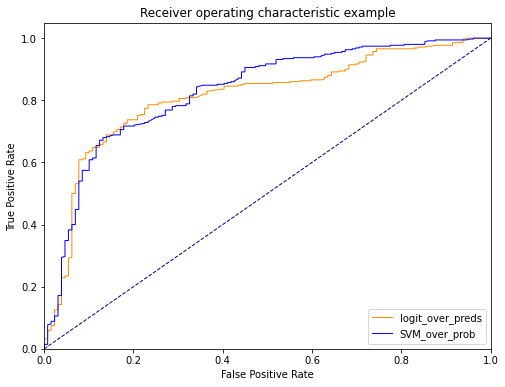

In [228]:
# COMPARE
from sklearn.metrics import roc_curve
plt.figure(figsize=(8,6))
lw = 1
fprNS2, tprNS2, _ = roc_curve(gValid.target, preds_2)
plt.plot(fprNS2, tprNS2, color='darkorange',
         lw=lw, label='logit_over_preds')
fprNS2, tprNS2, _ = roc_curve(gValid.target, prob_o_1[:,1])
plt.plot(fprNS2, tprNS2, color='blue',
         lw=lw, label='SVM_over_prob')

# fprNS2, tprNS2, _ = roc_curve(gValid.success, prob_o_3[:,1])
# plt.plot(fprNS2, tprNS2, color='red',
#          lw=lw, label='preds_1')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()